# Credit Card Customers

In this project, we will use data from a credit card company to build a binary classifier which predicts which customers will churn. The data can be obtained from [this dataset](https://www.kaggle.com/sakshigoyal7/credit-card-customers) on Kaggle. 

The author of the dataset gives an important note: if our model predicts non-churning customers as churning, it won't hurt the business. However, we do not want to make the opposite error of predicting churning customers as non-churning. So, we should allow our model to be *sensitive* at the price of being less precise. Thus we will measure the effectiveness of our model by measuring its **Recall**: 
$$ \mathrm{Recall} = \frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FN}}$$ 
where $\mathrm{TP}$ and $\mathrm{FN}$ denote the number of *true positives* and *false negatives* our model predicts on the validation set, assuming that "churning" is our positive class.  

The author was able to build a model that achieved 62% recall. The task is to build a model which improves this number. 

# Data Loading

The previous owner of the data makes a note that we should ignore or delete the last two columns of the data.

In [87]:
import pandas as pd
import numpy as np

In [88]:
df = pd.read_csv('BankChurners.csv').iloc[:,:-2]
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
CLIENTNUM                   10127 non-null int64
Attrition_Flag              10127 non-null object
Customer_Age                10127 non-null int64
Gender                      10127 non-null object
Dependent_count             10127 non-null int64
Education_Level             10127 non-null object
Marital_Status              10127 non-null object
Income_Category             10127 non-null object
Card_Category               10127 non-null object
Months_on_book              10127 non-null int64
Total_Relationship_Count    10127 non-null int64
Months_Inactive_12_mon      10127 non-null int64
Contacts_Count_12_mon       10127 non-null int64
Credit_Limit                10127 non-null float64
Total_Revolving_Bal         10127 non-null int64
Avg_Open_To_Buy             10127 non-null float64
Total_Amt_Chng_Q4_Q1        10127 non-null float64
Total_Trans_Amt             10127 non-null int

In [90]:
df.isnull().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

It appears that there is no null data, but further inspection shows that the null data has been changed to the string `'Unknown'`.

In [91]:
unknown = df == 'Unknown'
unknown.sum()

CLIENTNUM                      0
Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level             1519
Marital_Status               749
Income_Category             1112
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64

## Feature Descriptions

The `CLIENTNUM` column can probably be ignored since we can identify customers based on their row in the dataframe. The `Attrition_Flag` column provides the labels we will use for our supervised-learning task. There are 19 other columns which we are free to use as training data. 

* `Customer_Age`: Demographic variable - Customer's Age in Years.
* `Gender`: Demographic variable - M=Male, F=Female.
* `Dependent_count`: Demographic variable - Number of dependents
* `Education_Level`: Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)
* `Marital_Status`: Demographic variable - Married, Single, Divorced, Unknown.
* `Income_Category`: Demographic variable - Annual Income Category of the account holder (< \$40K, \$40K - 60K, \$60K - \$80K, \$80K-\$120K, > \$120k)
* `Card_Category`: Product Variable - Type of Card (Blue, Silver, Gold, Platinum)
* `Months_on_book`: Period of relationship with bank.
* `Total_Relationship_Count`: Total number of products held by the customer.
* `Months_Inactive_12_mon`: Number of months inactive in the last 12 months.
* `Contacts_Count_12_mon`: Number of contacts in the last 12 months.
* `Credit_Limit`: Credit limit on the credit card.
* `Total_Revolving_Bal`: Total revolving balance on the credit card (the portion of credit card spending that goes unpaid at the end of a billing cycle).
* `Avg_Open_To_Buy`: Open to buy credit line (Average of last 12 months). The difference between the credit limit assigned to a cardholder account and the present balance on the account.
* `Total_Amt_Chng_Q4_Q1`: Change in transaction amount (Q4 over Q1).
* `Total_Trans_Amt`: Total transaction amount (last 12 months).
* `Total_trans_Ct`: Number of transactions (last 12 months).
* `Total_Ct_Chng_Q4_Q1`: Change in transaction count (Q4 over Q1).
* `Avg_Utilization_Ratio`: Average percentage of credit used with respect to the credit limit.

We have 10,127 entries to work with, which should be plenty to get a good model.

In [92]:
df.drop(columns=['CLIENTNUM'], inplace=True)

# 'Attrited Customer' is the positive class
df['Attrition_Flag'].replace({'Existing Customer' : 0, 'Attrited Customer' : 1}, inplace=True)

In [93]:
# Customer churn is ~16%. 
df['Attrition_Flag'].value_counts(normalize=True)

0    0.83934
1    0.16066
Name: Attrition_Flag, dtype: float64

In [94]:
# Split data into training and testing sets. 
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=808)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

train_y = train_df['Attrition_Flag']
test_y = test_df['Attrition_Flag']

train_X = train_df.drop(columns=['Attrition_Flag'])
test_X = test_df.drop(columns=['Attrition_Flag'])

train_X.iloc[0:20, :]

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,56,M,3,College,Married,$120K +,Blue,43,6,2,2,17539.0,2517,15022.0,0.743,1220,30,0.765,0.144
1,42,F,2,Graduate,Unknown,Unknown,Blue,34,5,2,2,19373.0,1142,18231.0,0.655,1792,48,0.455,0.059
2,46,M,3,High School,Married,$80K - $120K,Blue,27,4,2,3,4964.0,2316,2648.0,0.793,3279,66,0.941,0.467
3,50,F,3,Uneducated,Single,Unknown,Blue,36,2,3,3,3187.0,986,2201.0,0.615,2381,47,0.516,0.309
4,51,M,1,Uneducated,Married,$60K - $80K,Blue,38,3,3,1,13731.0,1375,12356.0,0.878,14826,99,0.707,0.100
5,64,F,0,Uneducated,Married,Unknown,Blue,54,6,1,2,3250.0,1992,1258.0,0.715,1355,36,0.565,0.613
6,53,F,5,Graduate,Single,$40K - $60K,Blue,41,2,1,3,9815.0,1699,8116.0,0.620,7962,89,0.561,0.173
7,55,M,2,College,Married,$120K +,Blue,37,5,2,3,32641.0,1551,31090.0,0.488,1327,30,0.304,0.048
8,37,M,2,Doctorate,Single,$120K +,Blue,32,3,3,5,32056.0,1887,30169.0,0.831,2730,68,0.700,0.059
9,41,F,1,High School,Single,Less than $40K,Blue,31,4,2,1,1998.0,0,1998.0,0.717,4637,68,0.889,0.000


# Encoding categorical variables

Our data enjoys five different features whose values are represented as strings. We should encode these into numeric data before moving on.

In [95]:
from pandas.api.types import is_object_dtype

obj_cols = [c for c in train_X.columns if is_object_dtype(train_X[c])]
obj_cols

['Gender',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category']

## Gender

Unfortunately, the data only has two gender values. It is possible that customers of non-binary gender have significantly different attrition rates, but instead we will have to work within the very coarse framework given to us.

Integer encoding and one hot encoding are equivalent for a binary variable, so either one will work. 

In [96]:
train_X['Gender'].value_counts(normalize=True, dropna=False)

F    0.533144
M    0.466856
Name: Gender, dtype: float64

## Education Level

The values are ordered since the education levels follow a linear path, except that we have an `'Unknown'` value. We do not know why certain entries are labeled this way. We will assume it's because the customers chose not to provide this information, in which case this may be a useful category to keep. We will worry about these values later.

We will use integer encoding for this feature.

In [97]:
train_X['Education_Level'].value_counts(normalize=True, dropna=False)

Graduate         0.309098
High School      0.202074
Unknown          0.148747
Uneducated       0.143563
College          0.098136
Post-Graduate    0.051352
Doctorate        0.047031
Name: Education_Level, dtype: float64

## Marital Status

There is no linear ordering on these values. We will worry about ther `'Unknown'` values later.

We will use one hot encoding.

In [98]:
train_X['Marital_Status'].value_counts(normalize=True, dropna=False)

Married     0.463400
Single      0.390693
Divorced    0.073201
Unknown     0.072707
Name: Marital_Status, dtype: float64

## Income Category

The income categories may be sensibly ordered from smallest to largest. We will worry about the `'Unknown'` values later.

We will use integer encoding, from smallest to largest income. 

In [99]:
train_X['Income_Category'].value_counts(normalize=True)

Less than $40K    0.350697
$40K - $60K       0.176892
$80K - $120K      0.147513
$60K - $80K       0.139119
Unknown           0.114924
$120K +           0.070855
Name: Income_Category, dtype: float64

## Card Category

I will make the assumption that the card categories are ordered such that 
$$ \textrm{Blue} < \textrm{Silver} < \textrm{Gold} < \textrm{Platinum}.$$
The value counts for this feature gives evidence for this ordering.

In [100]:
train_X['Card_Category'].value_counts(normalize=True)

Blue        0.932107
Silver      0.054685
Gold        0.011357
Platinum    0.001852
Name: Card_Category, dtype: float64

## Summary

We will bundle these encodings together into one column-transformer which we will later use in a pipeline. 

In [101]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

encoder = make_column_transformer(
    (OneHotEncoder(drop='first'), 
        ['Gender', 'Marital_Status']),
    (OrdinalEncoder(categories=[
            ['Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate'],
            ['Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +'],
            ['Blue', 'Silver', 'Gold', 'Platinum']]), 
        ['Education_Level', 'Income_Category', 'Card_Category']),
    remainder='passthrough')

# Dealing With Missing Data

Recall that our `'Education_Level'`, `'Marital_Status'`, and `'Income_Category'` features contained a good amount of missing data. We will assume that this is not completely random; it may be the case that the customers willingly refused to provide this information to us. In this case, the missing data may be considered as data itself. 

We must make a choice for how to deal with this missing data. It would be nice if, at this step, we could fill in missing data intelligently without deleting any information. We may consider deleting features at a later step during feature selection.

First, we will create two new features `'Gave_Education'`, `'Gave_Marital_Status'` and `'Gave_Income'` which has value `'False'` if the corresponding feature is `'Unknown'`. Otherwise, it has value `'True'`.

After this, we will train a machine learning algorithm on the data without missing values to predict what the missing values might be.

## Creating New Features

In [102]:
train_X['Gave_Education'] = train_X['Education_Level'] != 'Unknown'
test_X['Gave_Education'] = test_X['Education_Level'] != 'Unknown'

train_X['Gave_Marital_Status'] = train_X['Marital_Status'] != 'Unknown'
test_X['Gave_Marital_Status'] = test_X['Marital_Status'] != 'Unknown'

train_X['Gave_Income'] = train_X['Income_Category'] != 'Unknown'
test_X['Gave_Income'] = test_X['Income_Category'] != 'Unknown'

train_X.tail()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gave_Education,Gave_Marital_Status,Gave_Income
8096,37,M,3,High School,Single,$80K - $120K,Blue,31,4,2,...,1006,4693.0,0.734,2835,57,0.900,0.177,True,True,True
8097,44,F,2,College,Married,$40K - $60K,Blue,39,4,1,...,775,926.0,0.847,4471,71,0.614,0.456,True,True,True
8098,33,F,4,College,Single,Less than $40K,Blue,36,1,3,...,0,1438.3,0.566,4641,85,0.700,0.000,True,True,True
8099,50,F,4,Doctorate,Married,Unknown,Silver,36,3,2,...,2096,32420.0,0.666,7042,73,0.553,0.061,True,True,False
8100,65,F,0,Uneducated,Single,Less than $40K,Blue,50,3,4,...,377,1320.0,1.048,2799,49,0.485,0.222,True,True,True


## Prepping Data for Imputer Model

Note that we won't use the features we've just created above. They would all be constant since we are restricting to data with no missing values.

In [103]:
not_missing_df = train_df[(train_df['Education_Level'] != 'Unknown') &
                          (train_df['Marital_Status']  != 'Unknown') &
                          (train_df['Income_Category'] != 'Unknown')  ].copy()

print('Number of rows: ', len(not_missing_df))
unknown = not_missing_df == 'Unknown'
unknown.sum()

Number of rows:  5658


Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [104]:
not_missing_X = not_missing_df.drop(columns=['Attrition_Flag', 'Education_Level', 'Marital_Status', 'Income_Category'], axis='columns')
not_missing_y1 = not_missing_df['Education_Level']
not_missing_y2 = not_missing_df['Marital_Status']
not_missing_y3 = not_missing_df['Income_Category']

not_missing_X.iloc[:10, :]

,Customer_Age,Gender,Dependent_count,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,56,M,3,Blue,43,6,2,2,17539.0,2517,15022.0,0.743,1220,30,0.765,0.144
2,46,M,3,Blue,27,4,2,3,4964.0,2316,2648.0,0.793,3279,66,0.941,0.467
4,51,M,1,Blue,38,3,3,1,13731.0,1375,12356.0,0.878,14826,99,0.707,0.100
6,53,F,5,Blue,41,2,1,3,9815.0,1699,8116.0,0.620,7962,89,0.561,0.173
7,55,M,2,Blue,37,5,2,3,32641.0,1551,31090.0,0.488,1327,30,0.304,0.048
8,37,M,2,Blue,32,3,3,5,32056.0,1887,30169.0,0.831,2730,68,0.700,0.059
9,41,F,1,Blue,31,4,2,1,1998.0,0,1998.0,0.717,4637,68,0.889,0.000
10,44,M,3,Blue,34,5,3,1,8997.0,708,8289.0,0.586,4558,62,0.676,0.079
11,38,F,2,Blue,36,2,3,2,7825.0,0,7825.0,0.724,14326,100,0.786,0.000
12,44,M,4,Silver,27,4,3,2,34516.0,1043,33473.0,0.690,4654,59,0.639,0.030


## Training An Imputer Model

Let's try a few different methods of imputing and pick the ones which have the best accuracy. We won't spend too much of our effort here since it is not the main task, but we will try a few different methods and pick the one which has the highest accuracy.

First, let's get a baseline accuracy by just picking the most common categories for each feature. 

In [105]:
mode1 = not_missing_df['Education_Level'].mode()[0]
mode2 = not_missing_df['Marital_Status'].mode()[0]
mode3 = not_missing_df['Income_Category'].mode()[0]

mode_score_1 = not_missing_df['Education_Level'].value_counts(normalize=True)[0]
mode_score_2 = not_missing_df['Marital_Status'].value_counts(normalize=True)[0]
mode_score_3 = not_missing_df['Income_Category'].value_counts(normalize=True)[0]

print(f'Most common education level: {mode1}')
print(f'Accuracy: {mode_score_1:.2f}\n')
print(f'Most common marital status: {mode2}')
print(f'Accuracy: {mode_score_2:.2f}\n')
print(f'Most common income category: {mode3}')
print(f'Accuracy: {mode_score_3:.2f}\n')

Most common education level: Graduate
Accuracy: 0.36

Most common marital status: Married
Accuracy: 0.50

Most common income category: Less than $40K
Accuracy: 0.40



### Random Forest Imputer

In [106]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

scaler = StandardScaler()

# This encoder is a restriction of the one we constructed above.
imputer_encoder = make_column_transformer(
                                (OneHotEncoder(drop='first'), 
                                 ['Gender']),
                                (OrdinalEncoder(categories=[['Blue', 'Silver', 'Gold', 'Platinum']]), 
                                 ['Card_Category']),
                                remainder='passthrough')

forest1 = RandomForestClassifier(random_state=808)
forest2 = RandomForestClassifier(random_state=808)
forest3 = RandomForestClassifier(random_state=808)

param_grid = {'forest__n_estimators':range(1, 50),
              'forest__max_depth':range(1, 20),
              'forest__max_features':range(1, 10)}

forest_pipe1 = Pipeline([('encoder', imputer_encoder), ('scaler', scaler), ('forest', forest1)])
forest_pipe2 = Pipeline([('encoder', imputer_encoder), ('scaler', scaler), ('forest', forest2)])
forest_pipe3 = Pipeline([('encoder', imputer_encoder), ('scaler', scaler), ('forest', forest3)])

forest_grid1 = RandomizedSearchCV(forest_pipe1, param_grid, cv=5, scoring='accuracy')
forest_grid2 = RandomizedSearchCV(forest_pipe2, param_grid, cv=5, scoring='accuracy')
forest_grid3 = RandomizedSearchCV(forest_pipe3, param_grid, cv=5, scoring='accuracy')

forest_grid1.fit(not_missing_X, not_missing_y1)
forest_grid2.fit(not_missing_X, not_missing_y2)
forest_grid3.fit(not_missing_X, not_missing_y3);


In [107]:

forest_score1 = forest_grid1.best_score_
forest_score2 = forest_grid2.best_score_
forest_score3 = forest_grid3.best_score_

forest_params1 = forest_grid1.best_params_
forest_params2 = forest_grid2.best_params_
forest_params3 = forest_grid3.best_params_

print(f'Education Level\nAccuracy: {forest_score1:.2f}\nBest params: {forest_params1}\n')
print(f'Marital Status\nAccuracy: {forest_score2:.2f}\nBest params: {forest_params2}\n')
print(f'Income Category\nAccuracy: {forest_score3:.2f}\nBest params: {forest_params3}\n')

Education Level
Accuracy: 0.36
Best params: {'forest__n_estimators': 41, 'forest__max_features': 2, 'forest__max_depth': 4}

Marital Status
Accuracy: 0.57
Best params: {'forest__n_estimators': 33, 'forest__max_features': 5, 'forest__max_depth': 6}

Income Category
Accuracy: 0.59
Best params: {'forest__n_estimators': 48, 'forest__max_features': 7, 'forest__max_depth': 9}



### $k$-Nearest Neighbors Imputer

In [108]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn1 = KNeighborsClassifier()
knn2 = KNeighborsClassifier()
knn3 = KNeighborsClassifier()

param_grid = {'knn__n_neighbors' : range(1, 30)}

knn_pipe1 = Pipeline([('encoder', imputer_encoder), ('scaler', scaler), ('knn', knn1)])
knn_pipe2 = Pipeline([('encoder', imputer_encoder), ('scaler', scaler), ('knn', knn2)])
knn_pipe3 = Pipeline([('encoder', imputer_encoder), ('scaler', scaler), ('knn', knn3)])

knn_grid1 = GridSearchCV(knn_pipe1, param_grid, cv=5, scoring='accuracy')
knn_grid2 = GridSearchCV(knn_pipe2, param_grid, cv=5, scoring='accuracy')
knn_grid3 = GridSearchCV(knn_pipe3, param_grid, cv=5, scoring='accuracy')

knn_grid1.fit(not_missing_X, not_missing_y1)
knn_grid2.fit(not_missing_X, not_missing_y2)
knn_grid3.fit(not_missing_X, not_missing_y3);

In [109]:
knn_score1 = knn_grid1.best_score_
knn_score2 = knn_grid2.best_score_
knn_score3 = knn_grid3.best_score_

knn_params1 = knn_grid1.best_params_
knn_params2 = knn_grid2.best_params_
knn_params3 = knn_grid3.best_params_

print(f'Education Level\nAccuracy: {knn_score1:.2f}\nBest params: {knn_params1}\n')
print(f'Marital Status\nAccuracy: {knn_score2:.2f}\nBest params: {knn_params2}\n')
print(f'Income Category\nAccuracy: {knn_score3:.2f}\nBest params: {knn_params3}\n')

Education Level
Accuracy: 0.34
Best params: {'knn__n_neighbors': 29}

Marital Status
Accuracy: 0.54
Best params: {'knn__n_neighbors': 17}

Income Category
Accuracy: 0.56
Best params: {'knn__n_neighbors': 29}



It looks like imputing with a random forest classifier is the way to go. For now, we will say this is good enough for our purposes. One possible improvement would be to try XGBoost, which can be seen as a more sophisticated version of a Random Forest (they are both ensemble methods based on decision trees). Another option would be to use some dimensionality reduction techniques beforehand. Finally, we might get better results if we trained the three models in sequence instead of training them in parallel.

## Imputing With Random Forest Classifiers

In [110]:
forest1 = RandomForestClassifier(random_state=808, n_estimators=25, max_features=6, max_depth=1)
forest2 = RandomForestClassifier(random_state=808, n_estimators=31, max_features=9, max_depth=18)
forest3 = RandomForestClassifier(random_state=808, n_estimators=31, max_features=9, max_depth=12)

forest_pipe1 = Pipeline([('encoder', imputer_encoder), ('scaler', scaler), ('forest', forest1)])
forest_pipe2 = Pipeline([('encoder', imputer_encoder), ('scaler', scaler), ('forest', forest2)])
forest_pipe3 = Pipeline([('encoder', imputer_encoder), ('scaler', scaler), ('forest', forest3)])

forest_pipe1.fit(not_missing_X, not_missing_y1)
forest_pipe2.fit(not_missing_X, not_missing_y2)
forest_pipe3.fit(not_missing_X, not_missing_y3);

In [111]:
missing_X1 = train_X.loc[(train_X.Education_Level == 'Unknown')].drop(labels=['Education_Level', 'Marital_Status', 'Income_Category'], axis='columns')
missing_X2 = train_X.loc[(train_X.Marital_Status == 'Unknown')].drop(labels=['Education_Level', 'Marital_Status', 'Income_Category'], axis='columns')
missing_X3 = train_X.loc[(train_X.Income_Category == 'Unknown')].drop(labels=['Education_Level', 'Marital_Status', 'Income_Category'], axis='columns')


y_hat1 = forest_pipe1.predict(missing_X1)
y_hat2 = forest_pipe2.predict(missing_X2)
y_hat3 = forest_pipe3.predict(missing_X3)


In [112]:
train_X.loc[train_X.Education_Level == 'Unknown', 'Education_Level'] = y_hat1
train_X.loc[train_X.Marital_Status == 'Unknown', 'Marital_Status'] = y_hat2
train_X.loc[train_X.Income_Category == 'Unknown', 'Income_Category'] = y_hat3


In [113]:
# Check to see that it worked.
print(train_X.shape)
train_X.Income_Category.value_counts(dropna=False)

(8101, 22)


Less than $40K    3433
$40K - $60K       1742
$80K - $120K      1208
$60K - $80K       1144
$120K +            574
Name: Income_Category, dtype: int64

## Baseline Model

Let's quickly train a logistic regression model to get a good baseline before we start using dimensionality reduction techniques. This way, we will be able to run sanity checks and see if our tehcniques are working towards improving the model or not.

In [114]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=808)
logreg_clf = Pipeline([('encoder', encoder), ('scaler', scaler), ('logreg', logreg)])

In [115]:
from sklearn.model_selection import cross_val_score

cross_val_score(logreg_clf, train_X, train_y, scoring='recall', cv=10).mean()

0.5908396946564884

# Feature Selection

Here, we will apply some dimensionality reduction techniques, with a focus on maintaining the explainability of our future model. At the core, our task is to solve a binary classification problem using a mix of categorical and numerical data. 

## Univariate Analysis

We will compare each of our features to our target variable. If the feature is of integer type, we will apply the $\chi^2$ test. For features of float type, we will perform an Analysis of Variance (ANOVA).

In [116]:
from sklearn.feature_selection import chi2, f_classif

In [117]:
from pandas.api.types import is_integer_dtype

int_cols = [c for c in train_X.columns if is_integer_dtype(train_X[c])]

for feature in int_cols:
    val_cts = train_X[feature].value_counts(sort=False)
    print(f'{feature} counts: \n {val_cts}')


Customer_Age counts: 
 28     25
32     82
36    175
40    282
44    403
48    381
52    310
56    208
60     94
64     33
68      2
29     51
33     99
37    217
41    288
45    393
49    394
53    308
57    176
61     73
65     81
73      1
26     69
30     58
34    107
38    240
42    344
46    389
50    354
54    239
58    132
62     78
66      2
70      1
27     27
31     72
35    155
39    278
43    382
47    384
51    321
55    216
59    119
63     55
67      3
Name: Customer_Age, dtype: int64
Dependent_count counts: 
 0     735
4    1282
1    1487
5     336
2    2069
3    2192
Name: Dependent_count, dtype: int64
Months_on_book counts: 
 16      25
20      64
24     127
28     231
32     233
36    1981
40     270
44     185
48     124
52      45
56      80
13      59
17      30
21      68
25     133
29     185
33     240
37     297
41     229
45     176
49     104
53      68
14      13
18      48
22      81
26     144
30     240
34     269
38     273
42     225
46     170
50    

In [118]:
import matplotlib.pyplot as plt

def stacked_hist(feature:str, df=train_df, target='Attrition_Flag'):
    plt.hist(x=[df.loc[train_df[target] == True,  feature],
                df.loc[train_df[target] == False, feature]],
             bins=100, stacked=True, color=['tab:orange','tab:blue'])
    plt.xlabel(feature)
    plt.show()


In [119]:
from sklearn.feature_selection import chi2, f_classif

def get_chi2(X, y):
    """
    Returns a dictionary where the keys are the features and the values are tuples (chi2, p-value).
    """
    X_dummy = pd.get_dummies(X)
    stats = {}
    features = X.columns
    stats_list = chi2(X_dummy, y)

    for i in range(len(features)):
        stats[features[i]] = (stats_list[0][i], stats_list[1][i])

    return stats


    for i in range(len(features)):
        stats[features[i]] = (stats_list[0][i], stats_list[1][i])

    return stats


def get_anova(X, y):
    """
    Returns a dictionary where the keys are the features and the values are tuples (chi2, p-value).
    """
    X_dummy = pd.get_dummies(X)
    stats = {}
    features = X.columns
    stats_list = f_classif(X_dummy, y)

    for i in range(len(features)):
        stats[features[i]] = (stats_list[0][i], stats_list[1][i])

    return stats


chi2_stats = get_chi2(train_X, train_y)
anova_stats = get_anova(train_X, train_y)

In [120]:
def univariate_summary(feature:str, chi2_stats:dict, anova_stats:dict, alpha:float=0.05):
    stacked_hist(feature)

    chi2_stat, chi2_p = chi2_stats[feature]
    chi2_is_ind = chi2_p < alpha

    anova_stat, anova_p = anova_stats[feature]
    anova_is_ind = anova_p < alpha

    print('Chi2 Stats:')
    print(f'Chi^2 Test: {chi2_stat:.3f}')
    print(f'p-value: {chi2_p:.3f}')
    print(f'{feature} is probably independent of target: {chi2_is_ind}\n')

    print('ANOVA Stats:')
    print(f'F-Test: {anova_stat:.3f}')
    print(f'p-value: {anova_p:.3f}')
    print(f'{feature} is probably independent of target: {anova_is_ind}')


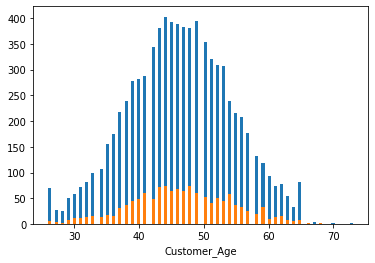

Chi2 Stats:
Chi^2 Test: 4.174
p-value: 0.041
Customer_Age is probably independent of target: True

ANOVA Stats:
F-Test: 2.984
p-value: 0.084
Customer_Age is probably independent of target: False


In [121]:
univariate_summary('Customer_Age', chi2_stats=chi2_stats, anova_stats=anova_stats)

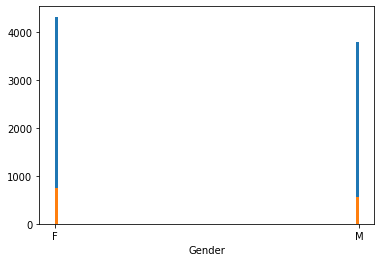

Chi2 Stats:
Chi^2 Test: 4.618
p-value: 0.032
Gender is probably independent of target: True

ANOVA Stats:
F-Test: 6.365
p-value: 0.012
Gender is probably independent of target: True


In [122]:
univariate_summary('Gender', chi2_stats=chi2_stats, anova_stats=anova_stats)

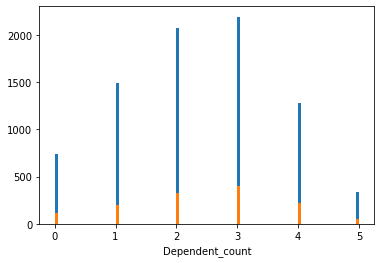

Chi2 Stats:
Chi^2 Test: 2.825
p-value: 0.093
Dependent_count is probably independent of target: False

ANOVA Stats:
F-Test: 1.589
p-value: 0.207
Dependent_count is probably independent of target: False


In [123]:
univariate_summary('Dependent_count', chi2_stats=chi2_stats, anova_stats=anova_stats)

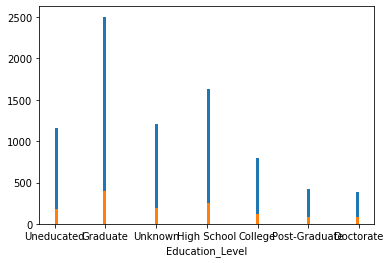

Chi2 Stats:
Chi^2 Test: 119.749
p-value: 0.000
Education_Level is probably independent of target: True

ANOVA Stats:
F-Test: 192.960
p-value: 0.000
Education_Level is probably independent of target: True


In [124]:
univariate_summary('Education_Level', chi2_stats=chi2_stats, anova_stats=anova_stats)

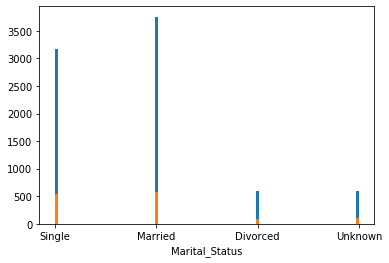

Chi2 Stats:
Chi^2 Test: 88.318
p-value: 0.000
Marital_Status is probably independent of target: True

ANOVA Stats:
F-Test: 209.858
p-value: 0.000
Marital_Status is probably independent of target: True


In [125]:
#interesting
univariate_summary('Marital_Status', chi2_stats=chi2_stats, anova_stats=anova_stats)

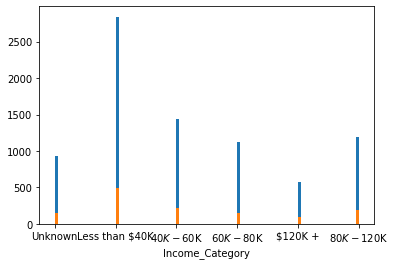

Chi2 Stats:
Chi^2 Test: 167.260
p-value: 0.000
Income_Category is probably independent of target: True

ANOVA Stats:
F-Test: 350.818
p-value: 0.000
Income_Category is probably independent of target: True


In [126]:
univariate_summary('Income_Category', chi2_stats=chi2_stats, anova_stats=anova_stats)

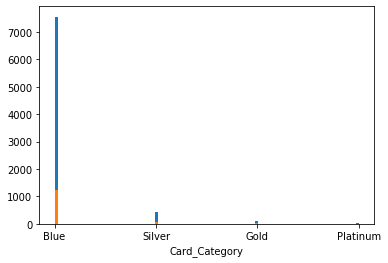

Chi2 Stats:
Chi^2 Test: 27782.585
p-value: 0.000
Card_Category is probably independent of target: True

ANOVA Stats:
F-Test: 2.936
p-value: 0.087
Card_Category is probably independent of target: False


In [127]:
univariate_summary('Card_Category', chi2_stats=chi2_stats, anova_stats=anova_stats)

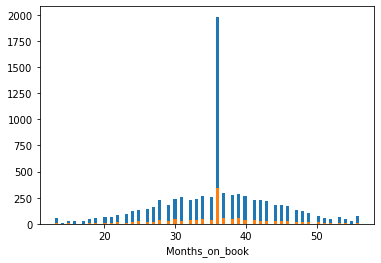

Chi2 Stats:
Chi^2 Test: 332829.677
p-value: 0.000
Months_on_book is probably independent of target: True

ANOVA Stats:
F-Test: 627.598
p-value: 0.000
Months_on_book is probably independent of target: True


In [128]:
univariate_summary('Months_on_book', chi2_stats=chi2_stats, anova_stats=anova_stats)

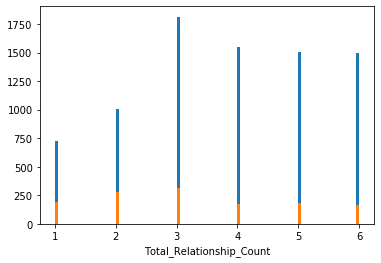

Chi2 Stats:
Chi^2 Test: 2347.326
p-value: 0.000
Total_Relationship_Count is probably independent of target: True

ANOVA Stats:
F-Test: 0.215
p-value: 0.643
Total_Relationship_Count is probably independent of target: False


In [129]:
#interesting
univariate_summary('Total_Relationship_Count', chi2_stats=chi2_stats, anova_stats=anova_stats)

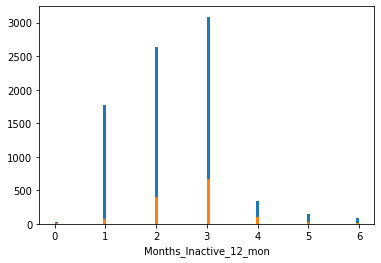

Chi2 Stats:
Chi^2 Test: 8.403
p-value: 0.004
Months_Inactive_12_mon is probably independent of target: True

ANOVA Stats:
F-Test: 134.571
p-value: 0.000
Months_Inactive_12_mon is probably independent of target: True


In [130]:
univariate_summary('Months_Inactive_12_mon', chi2_stats=chi2_stats, anova_stats=anova_stats)

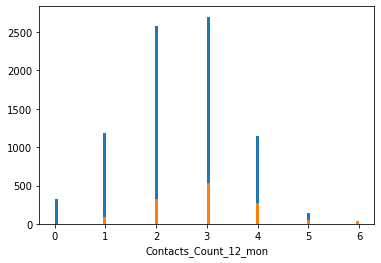

Chi2 Stats:
Chi^2 Test: 600302.092
p-value: 0.000
Contacts_Count_12_mon is probably independent of target: True

ANOVA Stats:
F-Test: 236.592
p-value: 0.000
Contacts_Count_12_mon is probably independent of target: True


In [131]:
univariate_summary('Contacts_Count_12_mon', chi2_stats=chi2_stats, anova_stats=anova_stats)

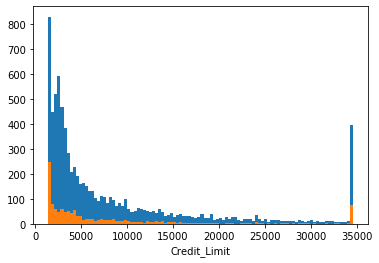

Chi2 Stats:
Chi^2 Test: 9607.434
p-value: 0.000
Credit_Limit is probably independent of target: True

ANOVA Stats:
F-Test: 1318.870
p-value: 0.000
Credit_Limit is probably independent of target: True


In [132]:
#interesting
univariate_summary('Credit_Limit', chi2_stats=chi2_stats, anova_stats=anova_stats)

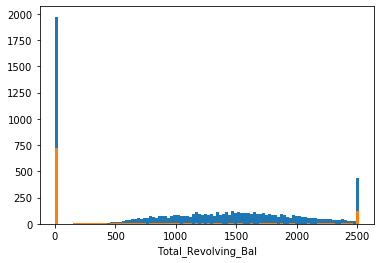

Chi2 Stats:
Chi^2 Test: 54.085
p-value: 0.000
Total_Revolving_Bal is probably independent of target: True

ANOVA Stats:
F-Test: 751.940
p-value: 0.000
Total_Revolving_Bal is probably independent of target: True


In [133]:
#interesting
univariate_summary('Total_Revolving_Bal', chi2_stats=chi2_stats, anova_stats=anova_stats)

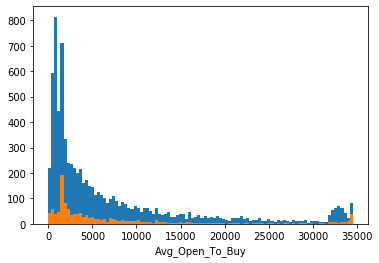

Chi2 Stats:
Chi^2 Test: 74.803
p-value: 0.000
Avg_Open_To_Buy is probably independent of target: True

ANOVA Stats:
F-Test: 280.964
p-value: 0.000
Avg_Open_To_Buy is probably independent of target: True


In [134]:
# Interesting. Weird snail thing at high values.
univariate_summary('Avg_Open_To_Buy', chi2_stats=chi2_stats, anova_stats=anova_stats)

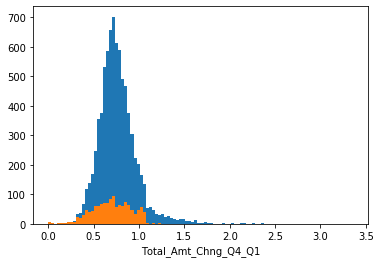

Chi2 Stats:
Chi^2 Test: 0.005
p-value: 0.944
Total_Amt_Chng_Q4_Q1 is probably independent of target: False

ANOVA Stats:
F-Test: 0.033
p-value: 0.856
Total_Amt_Chng_Q4_Q1 is probably independent of target: False


In [135]:
#interesting. Weird cutoff at 1.0.
univariate_summary('Total_Amt_Chng_Q4_Q1', chi2_stats=chi2_stats, anova_stats=anova_stats)

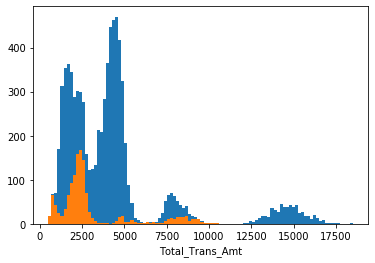

Chi2 Stats:
Chi^2 Test: 0.075
p-value: 0.784
Total_Trans_Amt is probably independent of target: False

ANOVA Stats:
F-Test: 1.035
p-value: 0.309
Total_Trans_Amt is probably independent of target: False


In [136]:
#interesting, compare to credit limit
univariate_summary('Total_Trans_Amt', chi2_stats=chi2_stats, anova_stats=anova_stats)

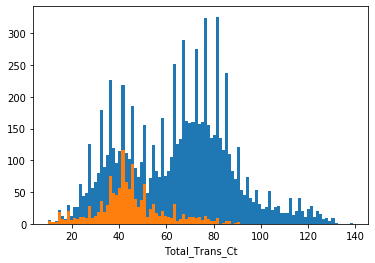

Chi2 Stats:
Chi^2 Test: 0.002
p-value: 0.963
Total_Trans_Ct is probably independent of target: False

ANOVA Stats:
F-Test: 0.019
p-value: 0.891
Total_Trans_Ct is probably independent of target: False


In [137]:
#interesting
# People who don't use the card as much are more likely to stop.
# Compare with revolving balance.
univariate_summary('Total_Trans_Ct', chi2_stats=chi2_stats, anova_stats=anova_stats)

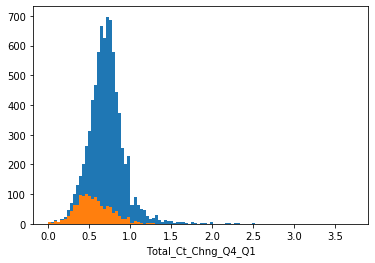

Chi2 Stats:
Chi^2 Test: 3.244
p-value: 0.072
Total_Ct_Chng_Q4_Q1 is probably independent of target: False

ANOVA Stats:
F-Test: 6.953
p-value: 0.008
Total_Ct_Chng_Q4_Q1 is probably independent of target: True


In [138]:
# interesting.
univariate_summary('Total_Ct_Chng_Q4_Q1', chi2_stats=chi2_stats, anova_stats=anova_stats)

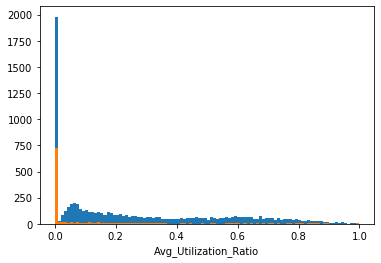

Chi2 Stats:
Chi^2 Test: 3.705
p-value: 0.054
Avg_Utilization_Ratio is probably independent of target: False

ANOVA Stats:
F-Test: 6.953
p-value: 0.008
Avg_Utilization_Ratio is probably independent of target: True


In [139]:
#interesting.
univariate_summary('Avg_Utilization_Ratio', chi2_stats=chi2_stats, anova_stats=anova_stats)

## Conclusions

It appears that the customers who don't use their card very much are those who are much more likely to stop using our service. 


* `Customer_Age`: ANOVA p-value is not small. We will keep this feature.
* `Gender`: Chi^2 p-value is small. We might consider removing this feature at a later time if we decide to make optimizations.
* `Dependent_count`: Chi^2 p-value is not small. We will keep this feature.
* `Education_Level`: Chi^2 p-value is very small. We should consider removing this feature.
* `Marital_Status`: Chi^2 p-value is very small. We should consider removing this feature.
* `Income_Category`: Chi^2 p-value is very small. We should consider removing this feature.
* `Card_Category`: The variance is very small. We should consider removing this feature.
* `Months_on_book`: Both p-values are very small. We should consider removing this feature.
* `Total_Relationship_Count`: Chi^2 p-value is very small. We should consider removing this feature.
* `Months_Inactive_12_mon`: Chi^2 p-value is very small. We should consider removing this feature. 
* `Contacts_Count_12_mon`: Chi^2 p-value is very small. We should consider removing this feature.
* `Credit_Limit`: ANOVA p-value is very small, but the histogram makes me suspicious. We will keep this feature for now.
* `Total_Revolving_Bal`: ANOVA p-value is small, but the histogram shows that there might be some relationship. I think we should replace this feature with a boolean feature `Total_Revolving_Bal_Is_Small`. 
* `Avg_Open_To_Buy`: ANOVA p-value is small, but I'm suspicious that this feature might be worth keeping. Perhaps we should try binning this one.
* `Total_Amt_Chng_Q4_Q1`: ANOVA p-value is high. We should keep this feature.
* `Total_Trans_Amt`: Intersting multi-modal distribution. Very obvious that this is a good feature to keep.
* `Total_trans_Ct`: Interesting bi-modal distribution. Very obvious that this is a good feature to keep.
* `Total_Ct_Chng_Q4_Q1`: Small ANOVA p-value, but high percentage of samples are churning at low values. This is a good feature to keep. 
* `Avg_Utilization_Ratio`: Small ANOVA p-value, but it's probably a good feature to keep or modify. We should try replacing the feature with `Avg_Utilization_Ratio_Is_Small`. 



In [140]:
train_X['Total_Revolving_Bal_Is_Small'] = train_X['Total_Revolving_Bal'] < 50
test_X['Total_Revolving_Bal_Is_Small'] = train_X['Total_Revolving_Bal'] < 50
train_df['Total_Revolving_Bal_Is_Small'] = train_df['Total_Revolving_Bal'] < 50

train_X['Avg_Utilization_Ratio_Is_Small'] = train_X['Avg_Utilization_Ratio'] < 0.01
test_X['Avg_Utilization_Ratio_Is_Small'] = train_X['Avg_Utilization_Ratio'] < 0.01
train_df['Avg_Utilization_Ratio_Is_Small'] = train_df['Avg_Utilization_Ratio'] < 0.01

print(train_X['Total_Revolving_Bal_Is_Small'].value_counts())
print(train_X['Avg_Utilization_Ratio_Is_Small'].value_counts())

False    6129
True     1972
Name: Total_Revolving_Bal_Is_Small, dtype: int64
False    6121
True     1980
Name: Avg_Utilization_Ratio_Is_Small, dtype: int64


It's interesting to see that the value counts for both of these features are almost the same. Perhaps these are roughly equivalent as features.

In [141]:
x = train_X['Total_Revolving_Bal_Is_Small'] & train_X['Avg_Utilization_Ratio_Is_Small']
x.value_counts()

False    6129
True     1972
dtype: int64

It appears that we are correct in assuming these two new features are roughly equivalent. Therefore, we will only keep one of them.

In [142]:
train_X.drop(columns=['Total_Revolving_Bal', 'Avg_Utilization_Ratio', 'Avg_Utilization_Ratio_Is_Small'], inplace=True)
test_X.drop(columns=['Total_Revolving_Bal', 'Avg_Utilization_Ratio', 'Avg_Utilization_Ratio_Is_Small'], inplace=True)

In [143]:
chi2_stats = get_chi2(train_X, train_y)
anova_stats = get_anova(train_X, train_y)

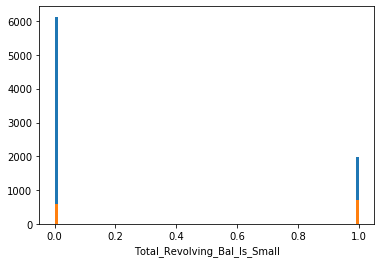

Chi2 Stats:
Chi^2 Test: 0.148
p-value: 0.701
Total_Revolving_Bal_Is_Small is probably independent of target: False

ANOVA Stats:
F-Test: 0.272
p-value: 0.602
Total_Revolving_Bal_Is_Small is probably independent of target: False


In [144]:
univariate_summary('Total_Revolving_Bal_Is_Small', chi2_stats=chi2_stats, anova_stats=anova_stats)

## Bivariate Analysis

In [149]:
def stacked_scatterplot(feature1:str, feature2:str, df=train_df, target='Attrition_Flag'):
    p0 = df.loc[df[target] == 0, [feature1, feature2]]
    p1 = df.loc[df[target] == 1, [feature1, feature2]]

    x0 = p0[feature1]
    y0 = p0[feature2]

    x1 = p1[feature1]
    y1 = p1[feature2]

    plt.scatter(x0, y0, c='tab:blue', label=f'{target}: False')
    plt.scatter(x1, y1, c='tab:orange', label=f'{target}: True')

    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend()
    plt.show()

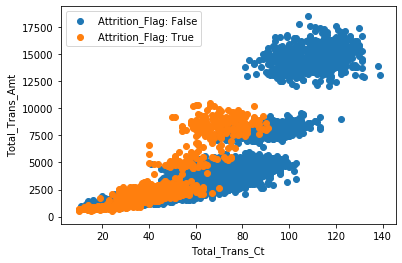

In [150]:
stacked_scatterplot('Total_Trans_Ct', 'Total_Trans_Amt')

In [ ]:
train_X.drop(columns=['Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book', 
                      'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon'], inplace=True)
test_X.drop(columns=['Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book', 
                     'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon'], inplace=True)